In [113]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

## 1. Описательный анализ

Song Popularity Dataset - набор песен, их параметров и показателя популярности. 

Показатели:
- song_name
- song_popularity (target)
- song_duration_ms - продолжительность,
- acousticness - уверенности от 0,0 до 1,0 в том, что дорожка является акустической,
- danceability - танцевальность описывает, насколько трек подходит для танцев, основываясь на сочетании музыкальных элементов, включая темп, стабильность ритма, силу такта и общую регулярность,
- energy - энергия имеет значение от 0,0 до 1,0 и представляет собой перцептивную меру интенсивности и активности,
- instrumentalness - чем ближе значение инструментальности к 1.0, тем больше вероятность того, что трек не содержит вокала,
- key - тональность, в которой находится трек. Если ключ не был обнаружен, значение равно -1
- liveness - вероятность того, что трек исполнен вживую,
- loudness - громкость трека в децибелах (дБ),
- audio_mode - мажор обозначается цифрой 1, а минор — цифрой 0,
- speechiness - наличие произносимых слов в треке,
- tempo - общий предполагаемый темп трека в ударах в минуту (BPM),
- time_signature - расчетная временная сигнатура (метр), сколько ударов в каждом такте (от 3 до 7, указывая на временные сигнатуры от "3/4" до "7/4"),
- audio_valence

Основная цель - предсказать популярность песни.

In [2]:
songs = pd.read_csv('song_data.csv')
target = 'song_popularity'
features = [i for i in songs.columns if i not in [target]]
print(f'Inference: The Datset consists of {songs.shape[1]} features & {songs.shape[0]} samples.')
songs.head()

Inference: The Datset consists of 15 features & 18835 samples.


,song_name,song_popularity,song_duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence
0,Boulevard of Broken Dreams,73,262333,0.005520,0.496,0.682,0.000029,8,0.0589,-4.095,1,0.0294,167.060,4,0.474
1,In The End,66,216933,0.010300,0.542,0.853,0.000000,3,0.1080,-6.407,0,0.0498,105.256,4,0.370
2,Seven Nation Army,76,231733,0.008170,0.737,0.463,0.447000,0,0.2550,-7.828,1,0.0792,123.881,4,0.324
3,By The Way,74,216933,0.026400,0.451,0.970,0.003550,0,0.1020,-4.938,1,0.1070,122.444,4,0.198
4,How You Remind Me,56,223826,0.000954,0.447,0.766,0.000000,10,0.1130,-5.065,1,0.0313,172.011,4,0.574


In [3]:
songs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18835 entries, 0 to 18834
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   song_name         18835 non-null  object 
 1   song_popularity   18835 non-null  int64  
 2   song_duration_ms  18835 non-null  int64  
 3   acousticness      18835 non-null  float64
 4   danceability      18835 non-null  float64
 5   energy            18835 non-null  float64
 6   instrumentalness  18835 non-null  float64
 7   key               18835 non-null  int64  
 8   liveness          18835 non-null  float64
 9   loudness          18835 non-null  float64
 10  audio_mode        18835 non-null  int64  
 11  speechiness       18835 non-null  float64
 12  tempo             18835 non-null  float64
 13  time_signature    18835 non-null  int64  
 14  audio_valence     18835 non-null  float64
dtypes: float64(9), int64(5), object(1)
memory usage: 2.2+ MB


### Поиск аномалий

<Axes: >

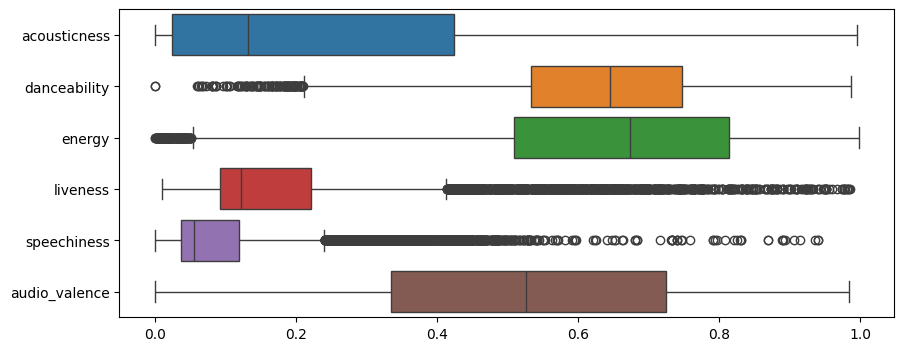

In [4]:
# Исключаем столбец song_duration_ms
songs_not_all = songs.drop(columns=['song_duration_ms', 'song_popularity','tempo', 'loudness', 'time_signature', 'key','audio_mode','instrumentalness'])

plt.figure(figsize = (10, 4))

# диаграмма размаха
sns.boxplot(data=songs_not_all, orient="h")

In [5]:
songs['audio_mode'].value_counts()

audio_mode
1    11831
0     7004
Name: count, dtype: int64

In [6]:
songs['instrumentalness'].value_counts()

instrumentalness
0.000000    7150
0.000003      37
0.001070      21
0.001140      20
0.000512      18
            ... 
0.000391       1
0.000064       1
0.000002       1
0.000804       1
0.276000       1
Name: count, Length: 3925, dtype: int64

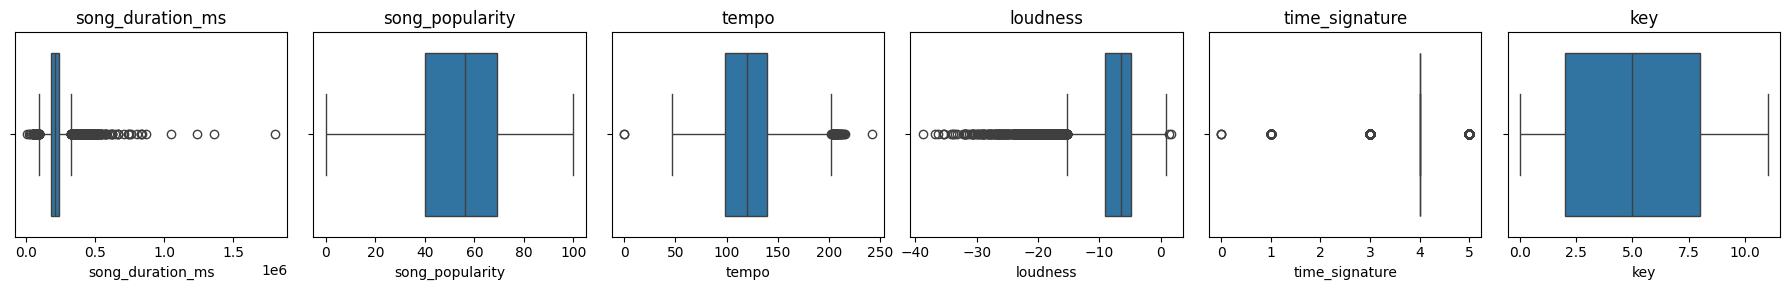

In [7]:
columns = ['song_duration_ms', 'song_popularity','tempo', 'loudness', 'time_signature', 'key']

# Количество столбцов для размещения графиков
num_cols = len(columns)

# Создание единой фигуры и осей
fig, axes = plt.subplots(1, num_cols, figsize=(num_cols * 3, 3), sharey=True)

for i, col in enumerate(columns):
    sns.boxplot(data=songs, x=col, ax=axes[i], orient="h")
    axes[i].set_title(col)

plt.tight_layout()
plt.show()

### Матрица корреляций

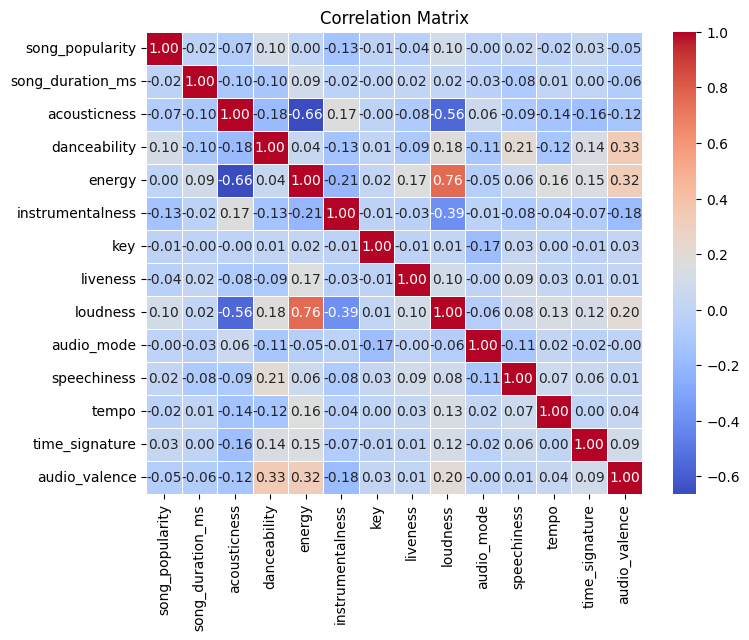

Корреляции с целевым показателем:
 song_popularity     1.000000
danceability        0.104290
loudness            0.099442
time_signature      0.034983
speechiness         0.021479
energy              0.001365
audio_mode         -0.004969
key                -0.013160
song_duration_ms   -0.018899
tempo              -0.022672
liveness           -0.038937
audio_valence      -0.052895
acousticness       -0.065181
instrumentalness   -0.130907
Name: song_popularity, dtype: float64


In [8]:
digit_cols = songs.drop(columns=['song_name'])

# Вычисление матрицы корреляций
correlation_matrix = digit_cols.corr()

# Визуализация тепловой карты
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

# Вычисление корреляции с целевым показателем
target_corr = correlation_matrix['song_popularity'].sort_values(ascending=False)
print("Корреляции с целевым показателем:\n", target_corr)

## 2. Построение базовых моделей

### a. Constant (среднее значение целевого показателя)

In [9]:
y = songs[target]

In [10]:
constant_prediction = y.mean()
constant_mse = mean_squared_error(y, [constant_prediction] * len(y))
print(f"Constant Model MSE: {constant_mse}")

Constant Model MSE: 479.8322143432033


### b. ConstantByGroup (среднее значение на основе тональности)

In [11]:
group_means = y.groupby(songs['key']).transform('mean')
constant_by_group_mse = mean_squared_error(y, group_means)
print(f"ConstantByGroup Model MSE: {constant_by_group_mse}")

ConstantByGroup Model MSE: 477.22310036532895


### c. OneParamMode (линейная регрессионная модель на базе танцевальности)

In [12]:
one_param = 'danceability'  # показатель с наибольшей корреляцией
X = songs[features]

# Обучение модели линейной регрессии на одном выбранном признаке
model = LinearRegression()
model.fit(X[[one_param]], y)
one_param_predictions = model.predict(X[[one_param]])
one_param_mse = mean_squared_error(y, one_param_predictions)
print(f"OneParamModel (Feature: {one_param}) MSE: {one_param_mse}")

OneParamModel (Feature: danceability) MSE: 474.6133510999583


## 3. Построение линейных регрессионных моделей

In [84]:
X = songs.drop(columns=[target])
y = songs[target]

In [52]:
# разделение признаков на количественные и категориальные
numeric_features = ['song_duration_ms', 'acousticness', 'danceability', 'energy',
       'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'audio_valence']
categorical_features = ['key', 'audio_mode', 'time_signature']

# ColumnTransformer для нормализации количественных признаков и кодирования категориальных
preprocessor_num = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features)         # Нормализация количественных признаков
    ])

### Модель на всех количественных показателях

Без нормализации показателей

In [149]:
# модель на всех количественных признаках
X_train, X_test, y_train, y_test = train_test_split(X[numeric_features], y, test_size=0.2, random_state=0)

model_num_no_scaling = LinearRegression()
model_num_no_scaling.fit(X_train, y_train)

# прогноз и оценка модели
y_pred = model_num_no_scaling.predict(X_test)
mse_num_no_scaling = mean_squared_error(y_test, y_pred)
r2_num_no_scaling = r2_score(y_test, y_pred)
print(f"MSE: {mse_num_no_scaling}\nr2: {r2_num_no_scaling}")

MSE: 464.6060116035866
r2: 0.05546030870418028


С нормализацией показателей

In [150]:
# нормализация
X_preprocessed = preprocessor_num.fit_transform(X[numeric_features])
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.2, random_state=0)

model_num_scaling = LinearRegression()
model_num_scaling.fit(X_train, y_train)

# прогноз и оценка модели
y_pred = model_num_scaling.predict(X_test)
mse_num_scaling = mean_squared_error(y_test, y_pred)
r2_num_scaling = r2_score(y_test, y_pred)
print(f"MSE: {mse_num_scaling}\nr2: {r2_num_scaling}")

MSE: 464.6060116035866
r2: 0.05546030870418028


### Модель на всех показателях

In [53]:
# ColumnTransformer для нормализации количественных признаков и кодирования категориальных
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),         # Нормализация количественных признаков
        ('cat', OneHotEncoder(drop='first'), categorical_features)  # Кодирование категориальных признаков
    ])

preprocessor_no_scaling = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numeric_features),
        ('cat', OneHotEncoder(drop='first'), categorical_features)
    ])

Без нормализации показателей

In [69]:
X_preprocessed = preprocessor_no_scaling.fit_transform(X)

# модель на всех количественных признаках
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.2, random_state=0)

model_all_no_scaling = LinearRegression()
model_all_no_scaling.fit(X_train, y_train)

# прогноз и оценка модели
y_pred = model_all_no_scaling.predict(X_test)
mse_all_no_scaling = mean_squared_error(y_test, y_pred)
r2_all_no_scaling = r2_score(y_test, y_pred)
print(f"MSE: {mse_all_no_scaling}\nr2: {r2_all_no_scaling}")

MSE: 463.45105909224606
r2: 0.05780831639516493


С нормализацией показателей

In [70]:
X_preprocessed = preprocessor.fit_transform(X)

# модель на всех количественных признаках
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.2, random_state=0)

model_all_scaling = LinearRegression()
model_all_scaling.fit(X_train, y_train)

# прогноз и оценка модели
y_pred = model_all_scaling.predict(X_test)
mse_all_scaling = mean_squared_error(y_test, y_pred)
r2_all_scaling = r2_score(y_test, y_pred)
print(f"MSE: {mse_all_scaling}\nr2: {r2_all_scaling}")

MSE: 463.4510590922461
r2: 0.057808316395164705


### Оценка влияния нормализации

In [72]:
print(f"""Модель на количественных признаках без нормализации - MSE: {mse_num_no_scaling}, r2: {r2_num_no_scaling}
Модель на количественных признаках с нормализацией - MSE: {mse_num_scaling}, r2: {r2_num_scaling}
Модель на всех признаках без нормализации - MSE: {mse_all_no_scaling}, r2: {r2_all_no_scaling}
Модель на всех признаках с нормализацией - MSE: {mse_all_scaling}, r2: {r2_all_scaling}""")


Модель на количественных признаках без нормализации - MSE: 464.6060116035866, r2: 0.05546030870418028
Модель на количественных признаках с нормализацией - MSE: 464.6060116035866, r2: 0.05546030870418028
Модель на всех признаках без нормализации - MSE: 463.45105909224606, r2: 0.05780831639516493
Модель на всех признаках с нормализацией - MSE: 463.4510590922461, r2: 0.057808316395164705


### Анализ весовых коэффициентов

In [73]:
print("Модель на количественных признаках без нормализации")
coefficients = pd.DataFrame({'Feature': numeric_features, 'Coefficient': model_num_no_scaling.coef_})
print(coefficients.sort_values('Coefficient', ascending=False))

print("\nМодель на количественных признаках с нормализацией")
coefficients = pd.DataFrame({'Feature': numeric_features, 'Coefficient': model_num_scaling.coef_})
print(coefficients.sort_values('Coefficient', ascending=False))

Модель на количественных признаках без нормализации
            Feature  Coefficient
2      danceability    10.745181
6          loudness     0.648408
0  song_duration_ms    -0.000004
8             tempo    -0.013662
7       speechiness    -3.341031
1      acousticness    -4.608176
5          liveness    -4.782624
9     audio_valence    -7.798224
4  instrumentalness   -11.012672
3            energy   -11.331058

Модель на количественных признаках с нормализацией
            Feature  Coefficient
6          loudness     2.481930
2      danceability     1.683969
0  song_duration_ms    -0.219705
7       speechiness    -0.348722
8             tempo    -0.392277
5          liveness    -0.688604
1      acousticness    -1.330432
9     audio_valence    -1.907642
3            energy    -2.425924
4  instrumentalness    -2.440240


In [130]:
print("\nМодель на всех признаках без нормализации")

coefficients = pd.DataFrame({'Feature': preprocessor_no_scaling.get_feature_names_out(), 'Coefficient': model_all_no_scaling.coef_})
coefficients = coefficients.sort_values('Coefficient', ascending=False)
html = coefficients.to_html(classes='table table-bordered table-striped', index=False)
display(HTML(f'<div style="max-height: 250px; width: 300px; overflow-y: scroll;">{html}</div>'))

print("\nМодель на всех признаках с нормализацией")
coefficients = pd.DataFrame({'Feature': preprocessor.get_feature_names_out(), 'Coefficient': model_all_scaling.coef_})
coefficients = coefficients.sort_values('Coefficient', ascending=False)
html = coefficients.to_html(classes='table table-bordered table-striped', index=False)
display(HTML(f'<div style="max-height: 250px; width: 300px; overflow-y: scroll;">{html}</div>'))


Модель на всех признаках без нормализации


Feature,Coefficient
num__danceability,9.783189
cat__key_6,1.472593
cat__key_1,1.346547
cat__key_11,0.781286
num__loudness,0.645687
cat__key_10,0.546006
cat__audio_mode_1,0.482958
cat__key_5,0.259268
num__song_duration_ms,-0.000003
num__tempo,-0.012534



Модель на всех признаках с нормализацией


Feature,Coefficient
num__loudness,2.471513
num__danceability,1.533207
cat__key_6,1.472593
cat__key_1,1.346547
cat__key_11,0.781286
cat__key_10,0.546006
cat__audio_mode_1,0.482958
cat__key_5,0.259268
num__song_duration_ms,-0.191526
num__tempo,-0.359903


## 4. Применение других регрессионных моделей

### Полиномиальная регрессия

In [98]:
X_poly = songs.drop(columns=['song_name', 'song_popularity'])

X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=42)

# создание полиномиальных признаков
poly_features = PolynomialFeatures(degree=3, include_bias=False)
X_train_poly = poly_features.fit_transform(X_train)
X_test_poly = poly_features.transform(X_test)

# масштабируем полиномиальные преобразования
scaler = StandardScaler()
X_train_poly_scaled = scaler.fit_transform(X_train_poly)
X_test_poly_scaled = scaler.transform(X_test_poly)

# регуляризация Ridge
alphas = [0.01, 0.1, 1, 10, 100]
results = []

for alpha in alphas:
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_train_poly_scaled, y_train)
    
    # оценка на обучающей выборке
    y_train_pred = ridge.predict(X_train_poly_scaled)
    mse_train = mean_squared_error(y_train, y_train_pred)
    r2_train = r2_score(y_train, y_train_pred)
    
    # оценка на тестовой выборке
    y_test_pred = ridge.predict(X_test_poly_scaled)
    mse_test = mean_squared_error(y_test, y_test_pred)
    r2_test = r2_score(y_test, y_test_pred)
    
    results.append({'alpha': alpha, 'MSE': mse_train, 'R2': r2_train, 'MSE': mse_test, 'R2': r2_test})

# Вывод результатов
for result in results:
    print(f"Alpha: {result['alpha']}")
    print(f"Train: \tMSE: {result['MSE']:.2f}, R2: {result['R2']:.2f}")
    print(f"Test: \tMSE: {result['MSE']:.2f}, R2: {result['R2']:.2f}\n")

Alpha: 0.01
Train: 	MSE: 449.30, R2: 0.07
Test: 	MSE: 449.30, R2: 0.07

Alpha: 0.1
Train: 	MSE: 447.03, R2: 0.07
Test: 	MSE: 447.03, R2: 0.07

Alpha: 1
Train: 	MSE: 442.12, R2: 0.08
Test: 	MSE: 442.12, R2: 0.08

Alpha: 10
Train: 	MSE: 438.38, R2: 0.09
Test: 	MSE: 438.38, R2: 0.09

Alpha: 100
Train: 	MSE: 437.04, R2: 0.09
Test: 	MSE: 437.04, R2: 0.09



Значение alpha позволяет контролировать степень регуляризации: чем больше alpha, тем сильнее регуляризация, что снижает переобучение

In [117]:
# Применение полиномиальных преобразований
X_train_poly = poly_features.fit_transform(X_train)
X_test_poly = poly_features.transform(X_test)

# Получение имен признаков из полиномиальных преобразований
feature_names = poly_features.get_feature_names_out(X_train.columns)

# Получение коэффициентов модели
coefficients = pd.DataFrame({'Feature': feature_names, 'Coefficient': ridge.coef_}).sort_values(by='Coefficient', ascending=False)

# Вывод коэффициентов
print("\nКоэффициенты полиномиальной регрессии с регуляризацией:")
html = coefficients.to_html(classes='table table-bordered table-striped', index=False)
display(HTML(f'<div style="max-height: 300px; width: 450px; overflow-y: scroll;">{html}</div>'))


Коэффициенты полиномиальной регрессии с регуляризацией:


Feature,Coefficient
key tempo^2,2.714874
energy speechiness^2,2.627685
song_duration_ms danceability instrumentalness,2.454636
acousticness^2 speechiness,2.426281
energy audio_valence^2,2.419655
song_duration_ms acousticness danceability,2.336479
speechiness tempo audio_valence,2.323027
danceability,2.320462
danceability loudness tempo,2.299097
song_duration_ms^3,2.263035


### Модель на основе дерева решений

In [108]:
tree_model = DecisionTreeRegressor(random_state=0)
tree_model.fit(X_train, y_train)

# прогноз и оценка модели
y_pred_tree = tree_model.predict(X_test)
mse_tree = mean_squared_error(y_test, y_pred_tree)
r2_tree = r2_score(y_test, y_pred_tree)
print(f"MSE: {mse_tree}, r2: {r2_tree}")

MSE: 568.6705723659696, r2: -0.17962674985192195


In [140]:

# Важность признаков в модели дерева решений
feature_importances_tree = pd.DataFrame({'Feature': X_train.columns, 'Importance': tree_model.feature_importances_}).sort_values(by='Importance', ascending=False)
print("\nВажность признаков для модели дерева решений:")
print(feature_importances_tree)


Важность признаков для модели дерева решений:
             Feature  Importance
0   song_duration_ms    0.107678
7           loudness    0.102993
2       danceability    0.099645
4   instrumentalness    0.098467
10             tempo    0.093774
1       acousticness    0.091819
12     audio_valence    0.090408
9        speechiness    0.088585
6           liveness    0.084766
3             energy    0.083253
5                key    0.043948
8         audio_mode    0.010606
11    time_signature    0.004058


### Модель случайного леса

In [126]:
forest_model = RandomForestRegressor(random_state=0, n_estimators=100)
forest_model.fit(X_train, y_train)

# Прогноз и оценка модели
y_pred_forest = forest_model.predict(X_test)
mse_forest = mean_squared_error(y_test, y_pred_forest)
r2_forest = r2_score(y_test, y_pred_forest)
print(f"MSE: {mse_forest}, r2: {r2_forest}")

MSE: 295.524783668828, r2: 0.3869755936032442


Важность признаков в модели случайного леса

In [132]:
feature_importances_forest = pd.DataFrame({'Feature': X_train.columns, 'Importance': forest_model.feature_importances_}).sort_values(by='Importance', ascending=False)
print("\nВажность признаков для модели случайного леса:")
print(feature_importances_forest)


Важность признаков для модели случайного леса:
             Feature  Importance
7           loudness    0.102573
2       danceability    0.101013
12     audio_valence    0.098611
0   song_duration_ms    0.095183
4   instrumentalness    0.094074
1       acousticness    0.093805
10             tempo    0.090724
3             energy    0.090057
9        speechiness    0.088357
6           liveness    0.087680
5                key    0.043245
8         audio_mode    0.009614
11    time_signature    0.005064


## 5. Сравнение важности показателей

<Axes: title={'center': 'Важность признаков дерева решений'}, xlabel='Feature', ylabel='Importance'>

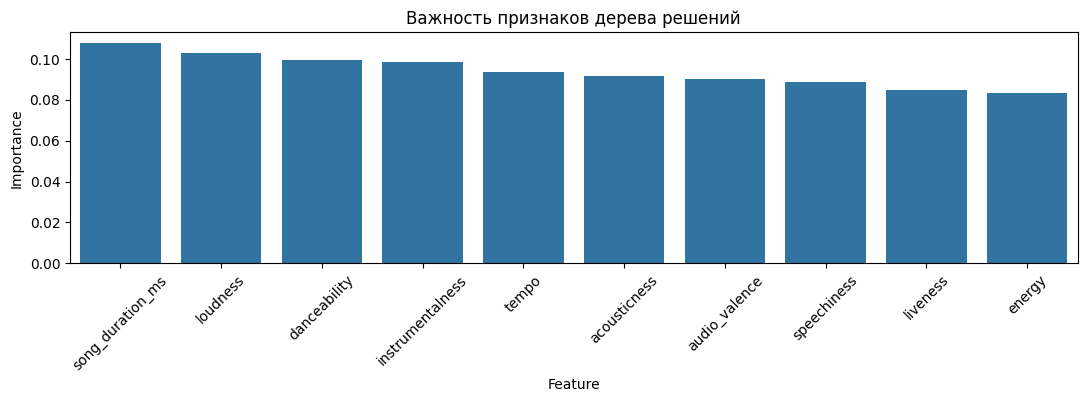

In [142]:
plt.figure(figsize=(13, 3))
plt.xticks(range(10), rotation=45)
plt.title("Важность признаков дерева решений")
sns.barplot(x = "Feature", y="Importance", data = feature_importances_tree)

<Axes: title={'center': 'Важность признаков случайного леса'}, xlabel='Feature', ylabel='Importance'>

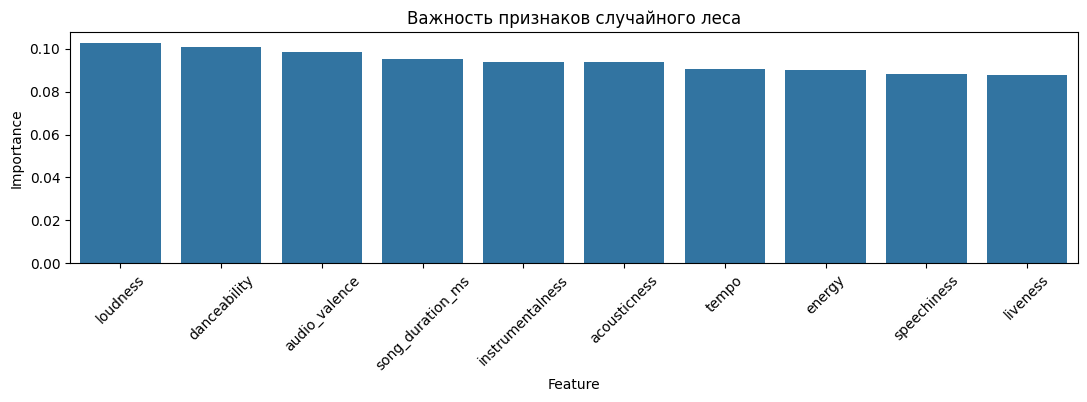

In [143]:
plt.figure(figsize=(13, 3))
plt.xticks(range(10), rotation=45)
plt.title("Важность признаков случайного леса")
sns.barplot(x = "Feature", y="Importance", data = feature_importances_forest)

Самыми важными признаками являются - loudness и danceability